## Imports

In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from time import time

## Finding patterns in text

In [2]:
def get_text(file_path):
    """ Gets text from file and returns numpy array containg that text and alphabet
    
    :arg
        file_path: path of the file from which function gets text
        
    :returns
        - numpy array with one letter in one cell and size n x m where n is number of
          lines in text and m is number of characters in the longest line 
        - set containing all characters which can be found in numpy array
    """
    with open(file_path) as file:
        text = file.read()

        # getting size
        line_length = 0
        curr_length = 0

        lines = 0

        for letter in text:
            if letter == '\n':
                lines += 1
                if curr_length > line_length:
                    line_length = curr_length

                curr_length = 0
            else:
                curr_length += 1

        # making matrix
        text_array = np.empty((lines, line_length), dtype=str)
        text_array.fill(' ')

        # writing letters to matrix
        line = 0
        letter_in_line = 0
        for letter in text:
            if letter == '\n':
                line += 1
                letter_in_line = 0
            else:
                text_array[line, letter_in_line] = letter
                letter_in_line += 1

        # getting alphabet
        alphabet = set(text)
        alphabet.remove('\n')

        return text_array, alphabet
    
    
def print_dict(d):
    d = list(d.items())
    d.sort()
    for i, j in d:
        print(f"{i} = {j}")

        
def make_transition_tables(pattern, alphabet, data_type=str):
    """ Makes transition tables for finding 2d pattern in text or image
    
    :arg
        pattern:   numpy array containing pattern which occurrences we want to find
        alphabet:  set of possible letters (if searching in text) or integers 
                   (if searching in image)
        data_type: str if searching in text, int if searching in image
        
    :returns
        - transition table (dictionary) of automaton for first stage of searching for
          pattern (by columns) which will narrow problem of searching pattern to 1 dimension
          for next automaton
        - transition table (dictionary) of automaton for second stage of searching for 
          pattern (by rows) which can return information whether the pattern is found or not
        - accepting state of second automaton to checking if pattern is found
    """
    # dictionary containing all transitions of first automaton
    table_col = dict()

    # making strings (if `data_type` == str) or lists (if `data_type` == int) 
    # from columns of pattern for future slicing
    pattern_col = []
    if data_type == str:
        for col in range(pattern.shape[1]):
            pattern_col.append("")
            for row in range(pattern.shape[0]):
                pattern_col[col] += pattern[row, col]
    else:
        for col in range(pattern.shape[1]):
            pattern_col.append([])
            for row in range(pattern.shape[0]):
                pattern_col[col].append(pattern[row, col])

    # sequence of states which will be read if pattern is found
    accepting_seq = []

    # all possible states of columns automaton
    states = {0}

    # making finite automaton for columns (to narrow problem of matching to 1d)
    for col in range(pattern.shape[1]):
        curr_state = 0
        for row in range(pattern.shape[0] + 1):
            for letter in alphabet:
                k = min(pattern.shape[0], row + 1)

                while k > 0:
                    for other_col in range(pattern.shape[1]):
                        if data_type == str:
                            part_to_compare = pattern_col[col][:row] + letter
                        else:
                            part_to_compare = pattern_col[col][:row]
                            part_to_compare.append(letter)
                        if pattern_col[other_col][:k] == part_to_compare[row - k + 1:]:
                            table_col[(curr_state, letter)] = other_col * pattern.shape[0] + k
                            k = 0
                            break

                    k -= 1

                if (curr_state, letter) not in table_col:
                    table_col[(curr_state, letter)] = 0

            if row < pattern.shape[0]:
                curr_state = table_col[(curr_state, pattern[row, col])]

            states.add(curr_state)

        accepting_seq.append(curr_state)

        for state in states:
            if table_col[(state, pattern[0, col])] == 0:
                table_col[(state, pattern[0, col])] = col * pattern.shape[0] + 1

    # dictionary containing all tansition of second automaton
    table_row = dict()

    # making finite automaton for rows using `accepting_seq` as if it was a 1d pattern to found
    for q in range(len(accepting_seq) + 1):
        for state in states:
            k = min(len(accepting_seq), q + 1)

            while k > 0 and accepting_seq[:k] != (accepting_seq[:q] + [state])[q - k + 1:]:
                k -= 1
            table_row[(q, state)] = k

    return table_col, table_row, len(accepting_seq)


def find_patterns(text_or_image, pattern, alphabet, data_type=str, *automata_args):
    """ Searches for pattern in text or image 
    
    :arg
        text_or_image: numpy array containing representation of text (as characters) 
                       or image (as integers - colors)
        pattern:       numpy array containing pattern which occurrences we want to find
        alphabet:      set of possible characters (if searching in text) or shades 
                       (if searching in image)
        data_type:     str if searching in text, int if searching in image
        automata_args: arguments which are results of making automata; passing them
                       prevent from calculating transition tables by this function
    
    :returns
        - list of tuples representing coordinates of found patterns (their bottom left corner)
    """
    
    # getting transition tables and accepting state
    if automata_args:
        table_col, table_row, accepting_state = automata_args
    else:
        table_col, table_row, accepting_state = make_transition_tables(pattern, alphabet, data_type)

    # finding matching columns using first automaton
    text_states = np.empty(text_or_image.shape, dtype=int)

    for i in range(text_or_image.shape[1]):
        if (0, text_or_image[0, i]) in table_col:
            text_states[0, i] = table_col[(0, text_or_image[0, i])]
        else:
            text_states[0, i] = 0

    for row in range(1, text_or_image.shape[0]):
        for col in range(text_or_image.shape[1]):
            if (text_states[row-1, col], text_or_image[row, col]) in table_col:
                text_states[row, col] = table_col[(text_states[row-1, col], text_or_image[row, col])]
            else:
                text_states[row, col] = 0

    # finding matching rows using second automaton and saving occurrences in `found` list
    found = []

    for row in range(pattern.shape[0] - 1, text_or_image.shape[0]):
        curr_state = 0

        for col in range(text_or_image.shape[1]):
            if (curr_state, text_states[row, col]) in table_row:
                curr_state = table_row[(curr_state, text_states[row, col])]

                if curr_state == accepting_state:
                    found.append((row, col))
                    curr_state = 0
            else:
                curr_state = 0

    return found


def get_all_letters():
    """ Returns list of all lowercase and uppercase letters. """
    lowercase = list(map(chr, range(ord('a'), ord('z')+1)))
    uppercase = list(map(chr, range(ord('A'), ord('Z')+1)))
    
    return lowercase + uppercase

### Same letter in consecutive lines

In [3]:
text, alphabet = get_text("haystack.txt")

letters = get_all_letters()

found_patterns = []

for letter in letters:
    pattern = np.empty((2, 1), dtype=str)
    pattern[:, :] = letter
    alphabet.add(letter)
    
    found_patterns += find_patterns(text, pattern, alphabet)

found_patterns.sort()

print(f"Number of occurrences: {len(found_patterns)}\n")
print(f"List of occurrences (line, position in line): {found_patterns}")

Number of occurrences: 235

List of occurrences (line, position in line): [(1, 7), (1, 63), (1, 82), (1, 83), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (4, 30), (4, 37), (4, 54), (4, 57), (4, 63), (5, 14), (5, 23), (5, 49), (5, 75), (5, 77), (6, 60), (6, 66), (7, 38), (7, 39), (7, 50), (7, 63), (8, 13), (8, 29), (8, 38), (8, 65), (9, 21), (9, 37), (9, 75), (10, 58), (10, 60), (11, 1), (11, 27), (11, 45), (11, 64), (14, 10), (14, 55), (15, 2), (15, 54), (16, 12), (16, 18), (16, 43), (16, 60), (17, 3), (17, 5), (18, 6), (18, 14), (19, 27), (20, 33), (20, 37), (20, 54), (20, 55), (21, 6), (21, 10), (21, 54), (21, 56), (22, 61), (22, 62), (22, 70), (23, 8), (23, 53), (24, 4), (25, 3), (25, 4), (25, 65), (28, 2), (28, 17), (28, 31), (29, 17), (29, 23), (29, 45), (29, 52), (29, 65), (29, 67), (29, 68), (29, 69), (29, 70), (29, 71), (29, 72), (29, 73), (30, 38), (30, 43), (30, 56), (31, 16), (31, 56), (31, 58), (31, 59), (32, 0), (32, 1), (32, 31), (32, 50), (32, 70), (32, 73), 

### Searching for pattern:

#### th

#### th

In [4]:
text, alphabet = get_text("haystack.txt")
pattern, _ = get_text("patterns/th.txt")

found_patterns = find_patterns(text, pattern, alphabet)

found_patterns.sort()

print(f"Number of occurrences: {len(found_patterns)}\n")
print(f"List of occurrences (line, position in line): {found_patterns}")

Number of occurrences: 0

List of occurrences (line, position in line): []


### Searching for pattern:

#### t h
#### t h

In [5]:
text, alphabet = get_text("haystack.txt")
pattern, _ = get_text("patterns/t_h.txt")

found_patterns = find_patterns(text, pattern, alphabet)

found_patterns.sort()

print(f"Number of occurrences: {len(found_patterns)}\n")
print(f"List of occurrences (line, position in line): {found_patterns}")

Number of occurrences: 1

List of occurrences (line, position in line): [(38, 2)]


## Cropping images

In [6]:
def crop_image(file_from, file_to, left, top, width, height):
    """ Gets part of the image, saves it to the file and returns 
    
    :arg
        file_from: path of the file in which is an image which the funtion crops
        file_to:   path of file in which function saves result subimage
        left, top: coordinates of the left top corner of subimage to cut out
        width:     width (in pixels) of subimage
        height:    heigh (in pixels) of subimage
        
    :returns
        cropped image
    """
    image = Image.open(file_from)
            
    subimage = image.crop((left, top, left + width, top + height))

    with open(file_to, "w+"):
        pass

    subimage.save(file_to)

    return subimage


def show_image(image, figsize, points=[], pattern=np.empty((1,1))):
    """ Showing image and (optionally) marked matchings 
    
    :arg
        image:   numpy array containing image
        figsize: size of the picture which will be displayed
        points:  matchings to show
        pattern: pattern which is needed to get its shape to mark matchings correctly          
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.imshow(image, cmap='gray')
    
    width = pattern.shape[1] + 1
    height = pattern.shape[0] + 1
    
    for point in points:
        rect = patches.Rectangle((point[1] - width, point[0] - height), 
                                 width+2, height+2, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

### Example of cropping "x" from "haystack.png"

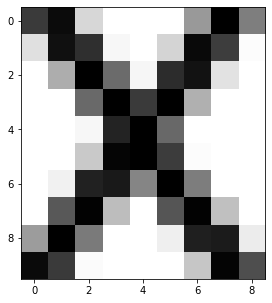

In [7]:
left = 487
top = 521
width = 9
height = 10

image = crop_image("haystack.png", "patterns/x.png", left, top, width, height)

show_image(image, (5, 5))

## Finding patterns in image

In [8]:
def get_pixels(file_path):
    """ Gets image from file 
    
    :arg
        file_path: path of the image
        
    :returns
        - numpy array containing all pixels of the image as numbers from 0 to 255
        - set of all pixels which can be found in the image
    """
    image = Image.open(file_path)
    
    image = image.convert("L")
    array = np.array(image, dtype=int)

    pixels = set()
    for x in np.unique(array):
        pixels.add(x)

    return array, pixels

### Finding "x" in the image

Number of occurrences: 57



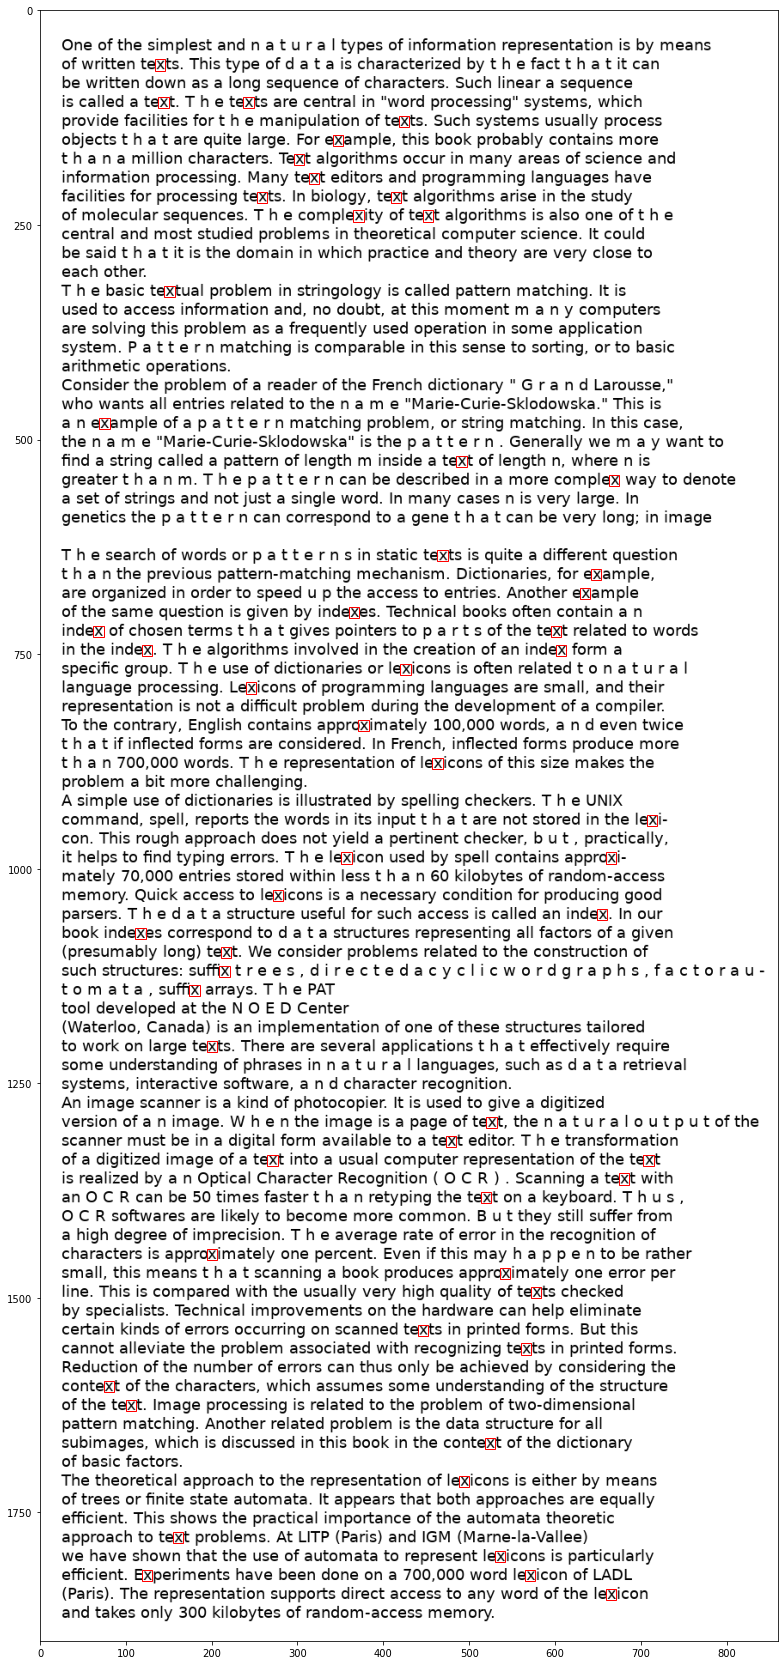

In [9]:
image, pixels = get_pixels("haystack.png")
x, _ = get_pixels("patterns/x.png")

found_patterns = find_patterns(image, x, pixels, data_type=int)

print(f"Number of occurrences: {len(found_patterns)}\n")
show_image(image, (20, 30), points=found_patterns, pattern=x)

### Finding "a" in the image

Number of occurrences: 397



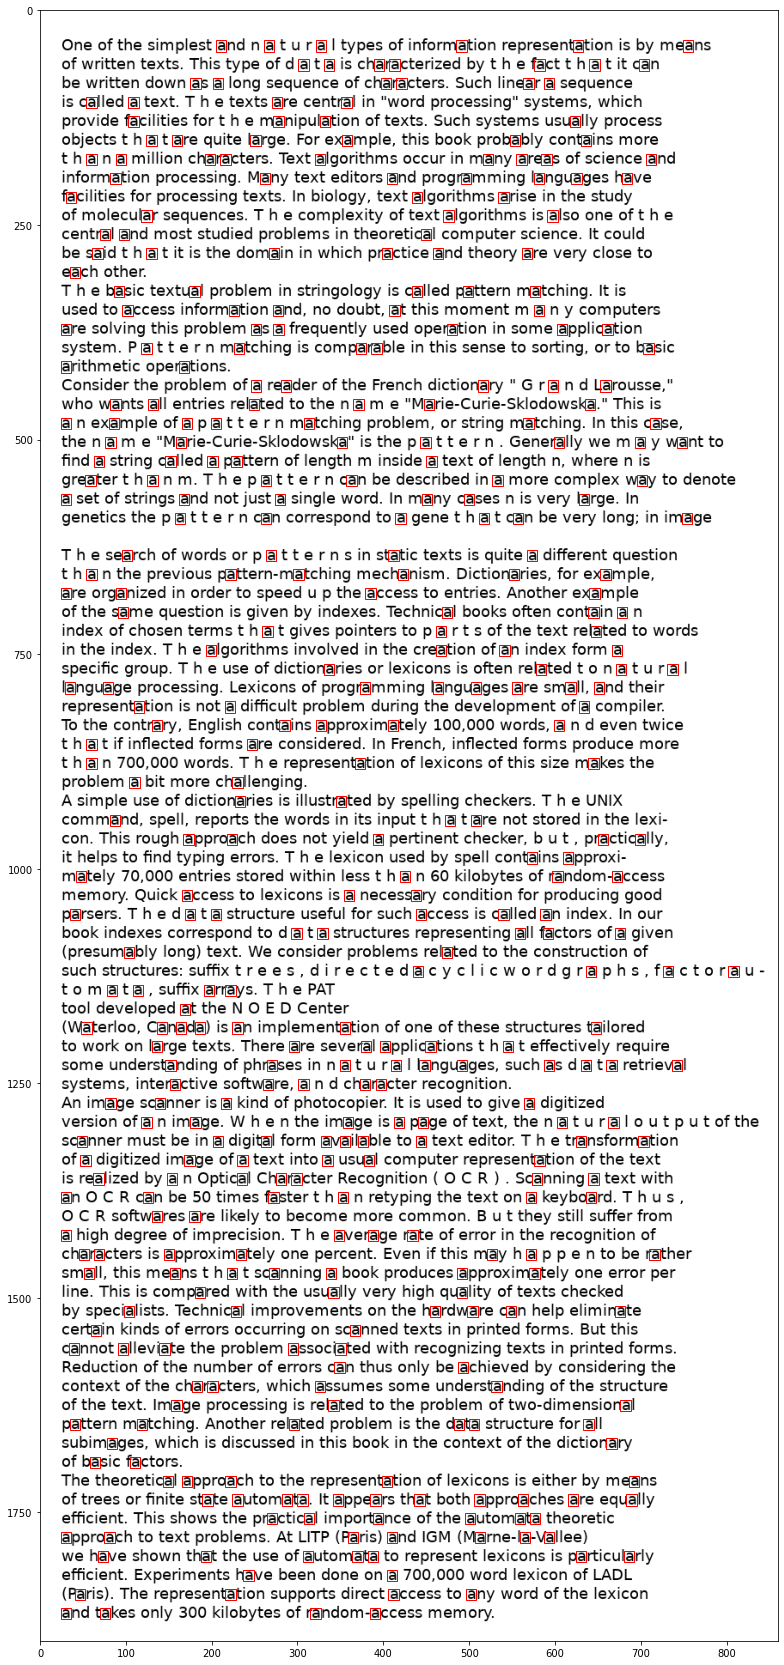

In [10]:
image, pixels = get_pixels("haystack.png")
a, _ = get_pixels("patterns/a.png")

found_patterns = find_patterns(image, a, pixels, data_type=int)

print(f"Number of occurrences: {len(found_patterns)}\n")
show_image(image, (20, 30), points=found_patterns, pattern=a)

### Finding "k" in the image

Number of occurrences: 22



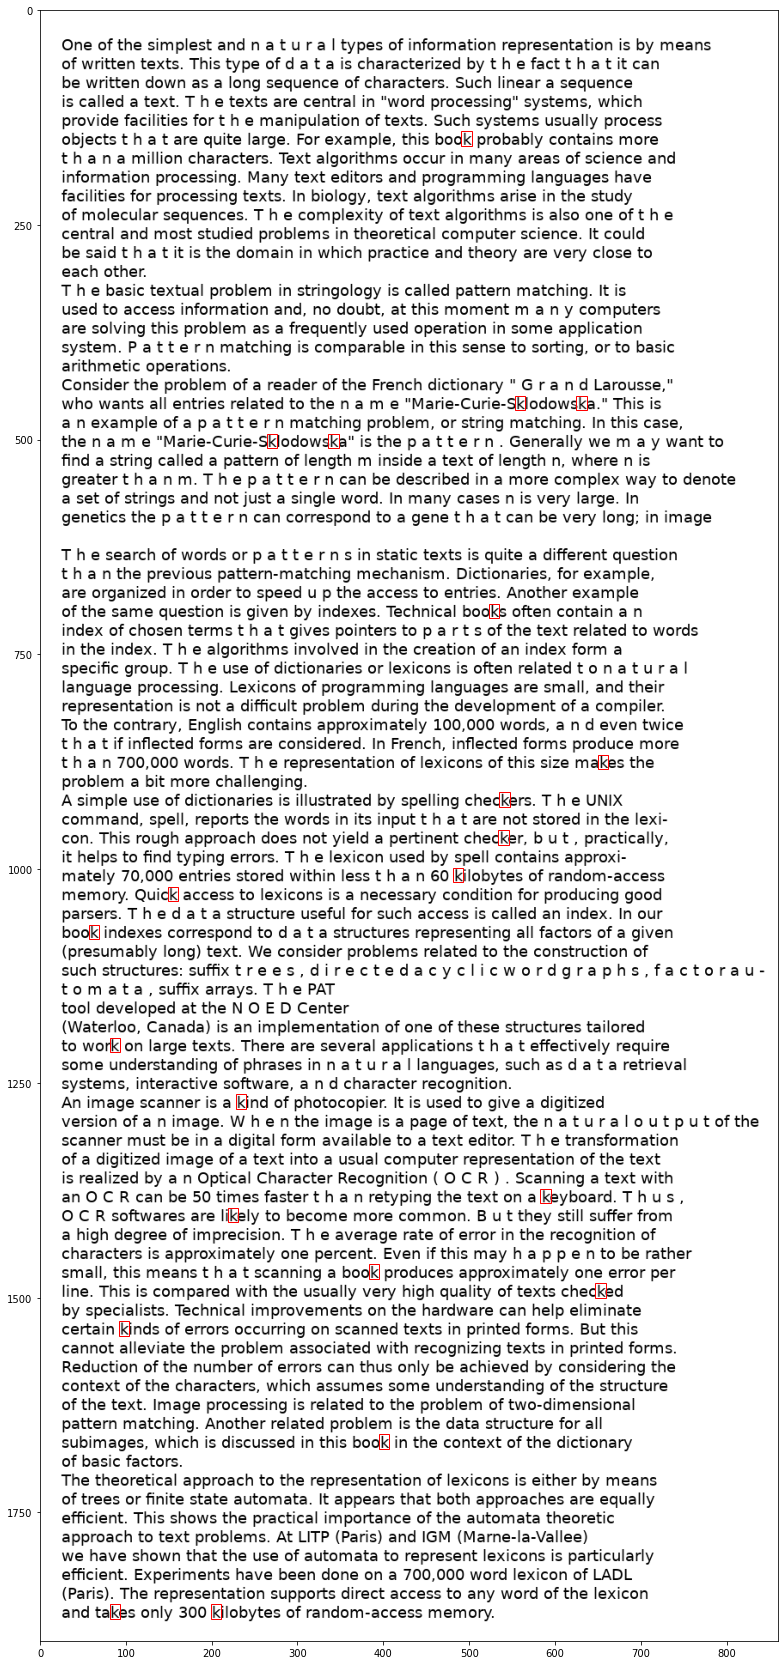

In [11]:
image, pixels = get_pixels("haystack.png")
k, _ = get_pixels("patterns/k.png")

found_patterns = find_patterns(image, k, pixels, data_type=int)

print(f"Number of occurrences: {len(found_patterns)}\n")
show_image(image, (20, 30), points=found_patterns, pattern=k)

### Finding "o" in the image

Number of occurrences: 369



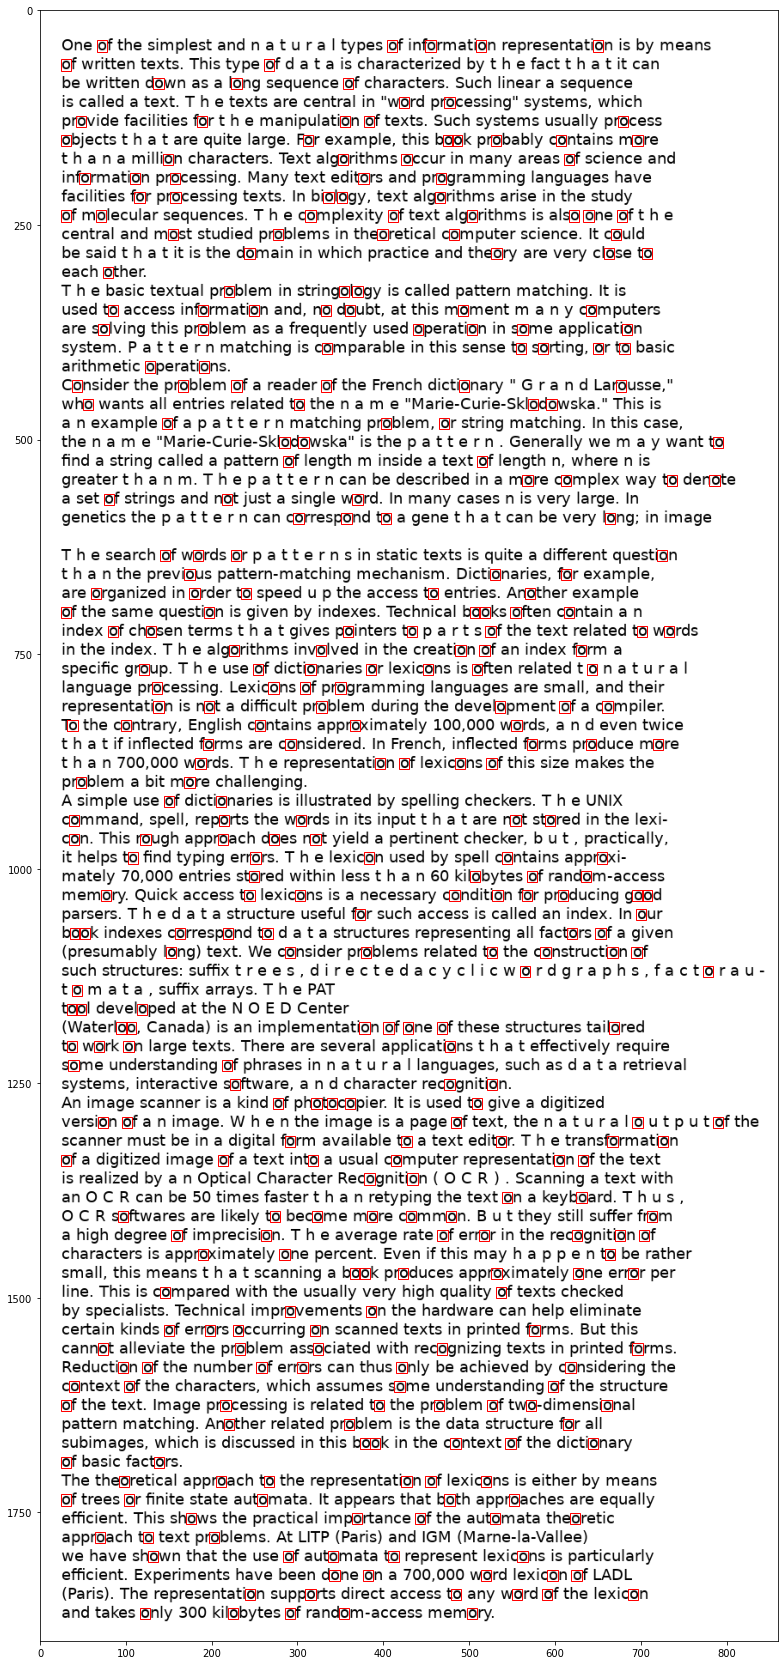

In [12]:
image, pixels = get_pixels("haystack.png")
o, _ = get_pixels("patterns/o.png")

found_patterns = find_patterns(image, o, pixels, data_type=int)

print(f"Number of occurrences: {len(found_patterns)}\n")
show_image(image, (20, 30), points=found_patterns, pattern=o)

### Finding "p a t t e r n" in the image

Number of occurrences: 5



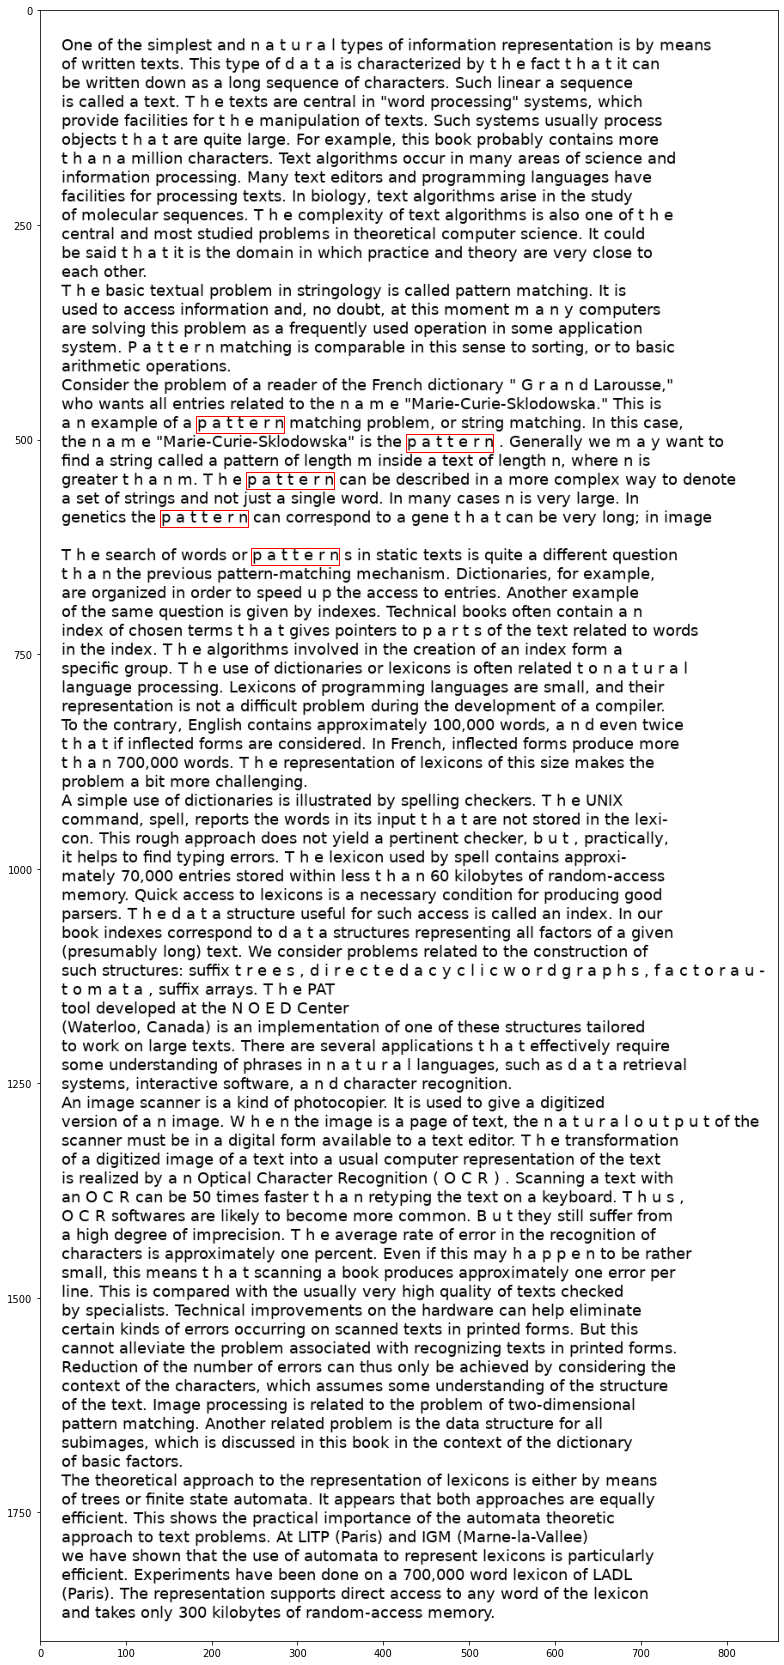

In [13]:
image, pixels = get_pixels("haystack.png")
pattern, _ = get_pixels("patterns/pattern.png")

found_patterns = find_patterns(image, pattern, pixels, data_type=int)

print(f"Number of occurrences: {len(found_patterns)}\n")
show_image(image, (20, 30), points=found_patterns, pattern=pattern)

### Time comparison

In [14]:
def divide_image(image, parts_num):
    """ Horizontally divides image to parts
    
    :arg
        image:     image to divide (as numpy array)
        parts_num: number of parts 
        
    :returns
        list of numpy arrays: parts of the image
    """
    parts = []
    start = 0
    for i in range(parts_num):
        part = image[:, i * image.shape[1] // parts_num : (i+1) * image.shape[1] // parts_num]
        parts.append(part)
        
    return parts

In [15]:
image, pixels = get_pixels("haystack.png")
small_pattern, _ = get_pixels("patterns/small_pattern.png")
medium_pattern, _ = get_pixels("patterns/medium_pattern.png")
big_pattern, _ = get_pixels("patterns/big_pattern.png")

#### Time of making automata

In [16]:
start_time = time()
small_col_table, small_row_table, small_accepting_seq = make_transition_tables(small_pattern, pixels, int)
small_tables_time = time() - start_time

start_time = time()
medium_col_table, medium_row_table, medium_accepting_seq = make_transition_tables(medium_pattern, pixels, int)
medium_tables_time = time() - start_time

start_time = time()
big_col_table, big_row_table, big_accepting_seq = make_transition_tables(big_pattern, pixels, int)
big_tables_time = time() - start_time

print("Time of making automata:")
print(f"Small pattern:  {small_tables_time}s")
print(f"Medium pattern: {medium_tables_time}s")
print(f"Big pattern:    {big_tables_time}s\n")

Time of making automata:
Small pattern:  0.08620405197143555s
Medium pattern: 0.772921085357666s
Big pattern:    71.6474347114563s



#### Time of search

In [19]:
def print_time_of_search(parts_num):
    """ Prints time of searching for pattern in the file 
    
    :arg
        parts_num: number of parts to which image will be divided before the search
    """
    parts = divide_image(image, parts_num)

    start_time = time()
    for part in parts:
        _ = find_patterns(
            part, small_pattern, pixels, int, small_col_table, small_row_table, small_accepting_seq)

    small_search_time = time() - start_time


    start_time = time()
    for part in parts:
        _ = find_patterns(
            part, medium_pattern, pixels, int, medium_col_table, medium_row_table, medium_accepting_seq)

    medium_search_time = time() - start_time


    start_time - time()
    for part in parts:
        _ = find_patterns(
            part, big_pattern, pixels, int, big_col_table, big_row_table, big_accepting_seq)

    big_search_time = time() - start_time


    print("Time of search:")
    print(f"Small pattern:  {small_search_time}s")
    print(f"Medium pattern: {medium_search_time}s")
    print(f"Big pattern:    {big_search_time}s")

#### Time of search - 1 file

In [22]:
print_time_of_search(1)

Time of search:
Small pattern:  3.554166078567505s
Medium pattern: 3.4912943840026855s
Big pattern:    6.706355810165405s


#### Time of search - 2 files

In [23]:
print_time_of_search(2)

Time of search:
Small pattern:  3.646150827407837s
Medium pattern: 4.2629008293151855s
Big pattern:    8.72610330581665s


#### Time of search - 4 files

In [24]:
print_time_of_search(4)

Time of search:
Small pattern:  4.226650238037109s
Medium pattern: 3.877927303314209s
Big pattern:    7.833650827407837s


#### Time of search - 8 files

In [25]:
print_time_of_search(8)

Time of search:
Small pattern:  5.146617650985718s
Medium pattern: 4.352368354797363s
Big pattern:    8.374860763549805s
